# Основы глубинного обучения, майнор ИАД.

# Галиуллин Руслан ИАД-1

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
!pip install wandb --upgrade --quiet
import wandb
# !wandb login
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 26.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2023-10-15 13:53:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [       <=>          ] 201.24M  39.5MB/s    in 5.4s    

2023-10-15 13:53:24 (37.3 MB/s) - ‘data.txt.zip’ saved [211011981]



In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [8]:
set_random_seed(42)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


model = Ridge(alpha=1.0)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
rmse_for_model = mean_squared_error(y_test, y_pred, squared=False)
rmse_for_model

9.510160820470436

Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
best_rmse_metric = mean_squared_error(y_test, np.full(len(y_test), np.mean(y_train)), squared=False)
best_rmse_metric

10.85246390513634

## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
# инициализируем проект
wandb.init(project="pytorch-hw01-task1")
# public https://wandb.ai/ruslan_iad/pytorch-hw01-task1?workspace=user-rmgaliullin

Epoch number,▁▂▄▅▇█▁▂▄▅▇█
Steps passed,▁▂▄▅▇█▁▂▄▅▇█
mean RMSE on test,█▇▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▆▆▄▂▂▂▂▂▁▁▂▁▁▂▁▂▁▁▁▂▁▁
mean RMSE on train,█▆▆▅▅▅▅▂▂▂▁▁
Epoch number,5
Steps passed,86952
mean RMSE on test,8.11976
mean RMSE on train,8.29165


In [ ]:
import torch.utils.data as data_utils

share = 1 # Если понадобиться тренировать только на срезе данных

X_train_torch = torch.tensor(X_train_scaled[:len(X_train_scaled) // share], dtype=torch.float32)
y_train_torch = torch.tensor(y_train[:len(y_train) // share], dtype=torch.float32)

X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

w = torch.rand(X_train_torch.size()[1], requires_grad=True, device=device, dtype=torch.float32)
b = torch.rand(1, requires_grad=True, device=device, dtype=torch.float32)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    data_utils.TensorDataset(X_train_torch, y_train_torch), batch_size=16, shuffle=True, num_workers=1
)

In [ ]:
train, test = [], []

for epoch in range(10):
    for x_train_iter, y_train_iter in tqdm(train_dataloader):  # берем батч из трейн лоадера
        y_pred = x_train_iter.to(device) @ w.t() + b
        loss = torch.sqrt(torch.mean((y_pred - y_train_iter.to(device)) ** 2))

        loss.backward()

        w.data -= 0.01 * w.grad
        b.data -= 0.01 * b.grad

        w.grad.data.zero_()
        b.grad.data.zero_()

    with torch.no_grad():
        def count_rmse(X, y):
          y_pred = X.to(device) @ w.t() + b # делаем предсказания
          loss = torch.sqrt(torch.mean((y_pred - y.to(device)) ** 2)) # считаем лосс
          return loss

        # Считаем на трейне
        train_rmse = count_rmse(X_train_torch, y_train_torch)
        train.append(train_rmse.cpu().numpy())

        # Считаем на тесте
        test_rmse = count_rmse(X_test_torch, y_test_torch)
        test.append(test_rmse.cpu().numpy())

        # скидываем метрики на wandb
        wandb.log(
            {
                "RMSE on trian": train[-1],
                "RMSE on test": test[-1],
            }
        )

        # печатаем метрики
        print(
            f"Epoch: {epoch}, train RMSE: {train[-1]}, test RMSE: {test[-1]}"
        )


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 0, train RMSE: 791.2861938476562, test RMSE: 791.3314208984375


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 1, train RMSE: 501.20733642578125, test RMSE: 501.2418212890625


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 2, train RMSE: 211.22528076171875, test RMSE: 211.29202270507812


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 3, train RMSE: 9.608259201049805, test RMSE: 9.544918060302734


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 4, train RMSE: 9.594951629638672, test RMSE: 9.527862548828125


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 5, train RMSE: 9.580707550048828, test RMSE: 9.53030014038086


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 6, train RMSE: 9.589138984680176, test RMSE: 9.523558616638184


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 7, train RMSE: 9.576952934265137, test RMSE: 9.528701782226562


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 8, train RMSE: 9.581768035888672, test RMSE: 9.524429321289062


  0%|          | 0/28983 [00:00<?, ?it/s]

Epoch: 9, train RMSE: 9.580857276916504, test RMSE: 9.532215118408203


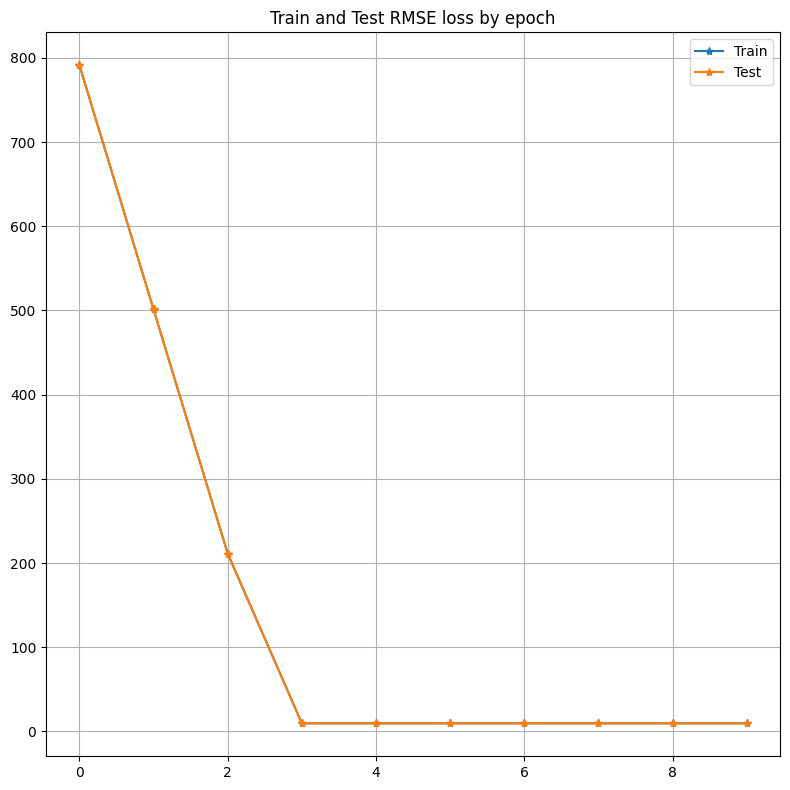

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(8, 8))

axes.plot(np.arange(len(train)), train, label="Train", marker='*')
axes.plot(np.arange(len(test)), test, label="Test", marker='*')
axes.legend()
axes.grid()
axes.set_title("Train and Test RMSE loss by epoch")
axes.set_xlabel('epoch')
axes.set_ylabel('RMSE')

plt.tight_layout()

plt.show()

Графики rmse на каждой эпохе на train и на test совпали, потому что значения очень близки были (видно по выводам)

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [9]:
# инициализируем проект
wandb.init(project="pytorch-hw01-task2")
# public https://wandb.ai/ruslan_iad/pytorch-hw01-task2?workspace=user-rmgaliullin

wandb: Currently logged in as: rmgaliullin (ruslan_iad). Use `wandb login --relogin` to force relogin


In [10]:
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat-y)**2))
# From https://discuss.pytorch.org/t/rmse-loss-function/16540/2

In [11]:
# На всякий заново определяем данные
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

# Проверка, что нет нанов
assert not df.isnull().sum().any()

# Проверка на категориальные признаки
categorical_list = []
numerical_list = []
for i in df.columns.tolist():
    if df[i].dtype=='object':
        categorical_list.append(i)
    else:
        numerical_list.append(i)
print('Number of categorical features:', len(categorical_list))
print('Number of numerical features:', len(numerical_list))

Number of categorical features: 0
Number of numerical features: 91


Очень мало какие признаки коррелируют с таргетом, только 7ой признак с коэф 0.27

In [12]:
k = 10
corrmat = df.corr()
cols = corrmat.nlargest(k, 0)[0].index.tolist()
cm = np.corrcoef(df[cols].values.T)

In [13]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

feature_scale = StandardScaler()
feature_scale.fit(X_train)
X_train_scaled = feature_scale.transform(X_train)
X_test_scaled = feature_scale.transform(X_test)

target_scaler = StandardScaler()
target_scaler.fit(y_train.reshape(-1, 1))
y_train_scaled = target_scaler.transform(y_train.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1))

In [14]:
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train_scaled, dtype=torch.float32).to(device)

X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
y_test_torch = torch.tensor(y_test_scaled, dtype=torch.float32).to(device)

In [15]:
from torch.utils.data import TensorDataset, DataLoader

train_set = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

test_set = TensorDataset(X_test_torch, y_test_torch)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

model = nn.Sequential(nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
                      nn.ReLU(),
                      nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
                      nn.ReLU(),
                      nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
                      nn.ReLU(),
                      nn.Linear(X_train_torch.size()[1], 1))

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.4)
criterion = RMSELoss

In [16]:
model.to(device)
wandb.watch(model);

In [17]:
from IPython import display

# Сохраняем значения шагов, на которых мы замеряем rmse и их стредние знаяения метрик
training = {'steps': [], "rmse": []}
testing = {'steps': [], "rmse": []}

def train(model, optimizer, criterion, train_loader, test_loader, epochs=6):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    i = 0

    for epoch in range(epochs):
        training_loss = []
        for x_train_iter, y_train_iter in tqdm(train_loader):
            wandb.log({"Epoch number": epoch, "Steps passed": i})
            y_pred = model(x_train_iter.to(device)) # Предсказание

            # Считаем отдельно rmse сдвинутое, учитывая нормировку таргета
            y_pred_scaled = y_pred * target_scaler.scale_[0] + target_scaler.mean_[0]
            y_train_iter_scaled = y_train_iter.to(device) * target_scaler.scale_[0] + target_scaler.mean_[0]
            loss_scaled = criterion(y_pred_scaled, y_train_iter_scaled)
            training_loss.append(loss_scaled.cpu().detach().numpy().item())

            # Считаем rmse для градиентного спуска
            loss = criterion(y_pred, y_train_iter.to(device))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Раз в 2000 шагов отрисовываем графики и пересчитываем rmse на тесте
            # Так как среднаяя rmse на трейне обнавляется только на каждой эпохе, то надо добавить epoch > 0
            if i % 2000 == 0 and epoch > 0:
              testing['steps'].append(i)
              test(model, criterion, test_loader)

              # Display the updated plot
              display.clear_output(True)
              fig, axes = plt.subplots(1, 2, figsize=(12, 5))
              axes[0].set_title("Train RMSE by learning step")
              axes[1].set_title("Test RMSE by learning step")

              axes[0].plot(training['steps'], training['rmse'], label="Train")
              axes[0].legend()
              axes[0].grid()
              axes[0].set_xlabel('step')
              axes[0].set_ylabel('RMSE')

              axes[1].plot(testing['steps'], testing['rmse'], label="Test")
              axes[1].legend()
              axes[1].grid()
              axes[1].set_xlabel('step')
              axes[1].set_ylabel('RMSE')

              plt.tight_layout()
              plt.show()
            i += 1

        training['steps'].append(i)
        training['rmse'].append(np.mean(training_loss))

        wandb.log({"mean RMSE on train": np.mean(training_loss)})


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    predicts = []

    with torch.no_grad():
        test_loss = []
        for x_test_iter, y_test_iter in tqdm(test_loader):
            y_pred = model(x_test_iter)
            predicts.extend(y_pred.cpu().numpy().tolist())

            y_pred_scaled = y_pred * target_scaler.scale_[0] + target_scaler.mean_[0]
            y_test_iter_scaled = y_test_iter.to(device) * target_scaler.scale_[0] + target_scaler.mean_[0]
            loss = criterion(y_pred_scaled, y_test_iter_scaled)
            test_loss.append(loss.cpu().detach().numpy().item())
        testing['rmse'].append(np.mean(test_loss))

        wandb.log(
            {
                "mean RMSE on test": np.mean(test_loss)
            }
        )
    return np.array(predicts)


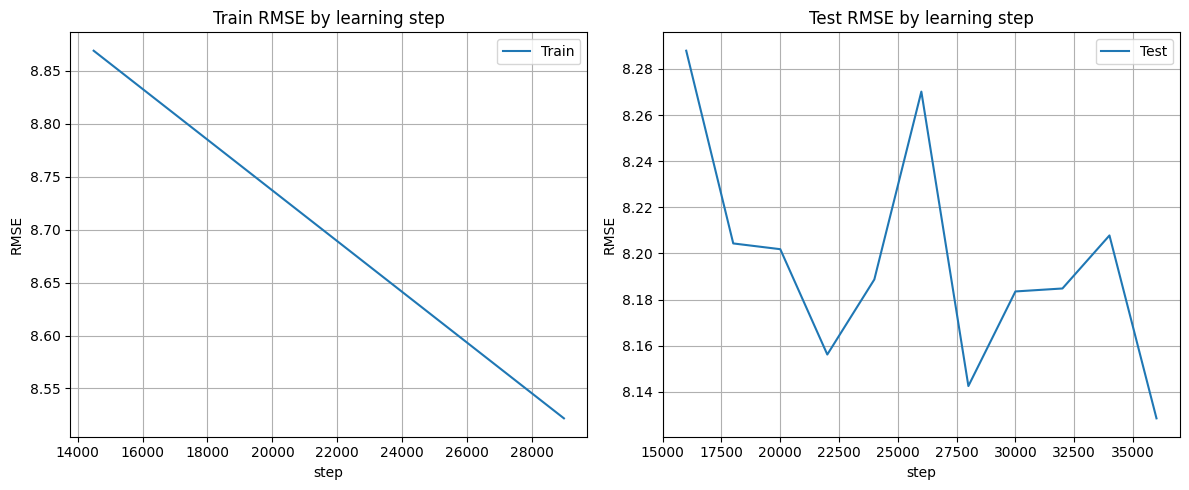

In [ ]:
train(model, optimizer, criterion, train_loader, test_loader)

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/404 [00:00<?, ?it/s]

#### Итоговые значения RMSE


In [ ]:
with torch.no_grad():
    train_loss = []
    for x_train_iter, y_train_iter in tqdm(train_loader):
        y_pred = model(x_train_iter.to(device))
        y_pred = y_pred * target_scaler.scale_[0] + target_scaler.mean_[0]
        y_train_iter = y_train_iter.to(device) * target_scaler.scale_[0] + target_scaler.mean_[0]
        loss = criterion(y_pred, y_train_iter.to(device))
        train_loss.append(loss.cpu().detach().numpy().item())
    test_loss = []
    for x_test_iter, y_test_iter in tqdm(test_loader):
        y_pred = model(x_test_iter)
        y_pred = y_pred * target_scaler.scale_[0] + target_scaler.mean_[0]
        y_test_iter = y_test_iter.to(device) * target_scaler.scale_[0] + target_scaler.mean_[0]
        loss = criterion(y_pred, y_test_iter.to(device))
        test_loss.append(loss.cpu().detach().numpy().item())
    print(f'Train RMSE: {np.mean(train_loss)}\nTest RMSE: {np.mean(test_loss)}')

  0%|          | 0/14492 [00:00<?, ?it/s]

  0%|          | 0/404 [00:00<?, ?it/s]

Train RMSE: 8.250998823592717
Test RMSE: 8.05871729744543


## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

## Тест 1


1.   Архитектура: `nn.Linear(X_train_torch.size()[1], 45), nn.ReLU(), nn.Linear(45,20), nn.ReLU(), nn.Linear(20, 1)`
2.   Масштабирование признаков standard scaler'ом
3.   Обалдели как сильно переобучается нейронка: RMSE_train = 2, RMSE_test = 1438+-
4.   Скрин графиков при обучении: [pict1](https://wampi.ru/image/YcVBYbg)
5.   Из гипер параметров: шаг = 0.0001, небольшой, чтобы нанов небыло в градиентах, батчи на тесте и трейне по 32

*Мысли*: лос на трейне уменьшился до целевых значений, но на тесте 1300+, поэтому попробуем добавить что-то против переобучения

<img src="https://ic.wampi.ru/2023/10/14/SNIMOK-EKRANA-2023-10-14-V-19.26.28.png" alt="drawing" width="400"/>


## Тест 2


1.   Архитектура:

```
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.Dropout(0.8),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], 2000),
 nn.ReLU(),
 nn.Linear(2000, 1)
```


2.   Масштабирование признаков standard scaler'ом
3.   Обалдели как сильно переобучается нейронка: RMSE_train = 15.655022621154785, RMSE_test = 1299.8341064453125
4.   Из гипер параметров: lr=0.001, momentum=0.9, epochs=10, батчи на тесте и трейне по 32

*Мысли*: получилось избавится от переобучения за счет dropout'а, но на тесте все равно ужасно плохой результат

<img src="https://im.wampi.ru/2023/10/14/SNIMOK-EKRANA-2023-10-14-V-20.29.29.png" alt="drawing" width="400"/>

## Тест 3


1.   Архитектура:

```
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.Dropout(0.8),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], 2000),
 nn.ReLU(),
 nn.Linear(2000, 1)
```


2.   Масштабирование признаков standard scaler'ом
3.   RMSE_train = 71.05, RMSE_test = 71.29
4.   Из гипер параметров: lr=0.001, momentum=0, epochs=10, батчи на тесте и трейне по 32

*Мысли*: сделали momentum=0 и rmse стало хорошим, значит 0.9 было слишком много и вываливался из оптимума при спуске

<img src="https://ic.wampi.ru/2023/10/14/SNIMOK-EKRANA-2023-10-14-V-21.09.24.png" alt="drawing" width="400"/>


## Тест 4


1.   Архитектура:

```
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.Dropout(0.8),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], 2000),
 nn.ReLU(),
 nn.Linear(2000, 1)
```


2.   Масштабирование признаков standard scaler'ом
3.   RMSE_train = 71.05, RMSE_test = 71.29
4.   Из гипер параметров: lr=0.001, momentum=0.5, epochs = 5, батчи на тесте и трейне по 32

*Мысли*: сделали momentum=0 и rmse не извенилось, значит скорее всего нет проблем с локальными минимумами, поставим в значение 0.1 в дальнейших тестах

## Тест 5


1.   Архитектура:

```
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.Dropout(0.8),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], 1)
```


2.   Масштабирование признаков standard scaler'ом
3.   RMSE_train = 64.70394897460938, RMSE_test = 65.38912963867188
4.   Из гипер параметров: lr=0.001, momentum=0.1, epochs=5, батчи на тесте и трейне по 32
5.   Теперь количество нейронов на каждом линейном слое == количеству признаков

*Мысли*: Немного получше, попробуем добавить еще один такой же слой из 90 нейронов, а DropOut перенесем в начало и сделаем 0.2 (так видел в интернете)

## Тест 6


1.   Архитектура:

```
 nn.Dropout(0.2),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], 1)
```


2.   Масштабирование признаков standard scaler'ом
3.   RMSE_train = 41.42428207397461, RMSE_test: 41.47001647949219
4.   Из гипер параметров: lr=0.001, momentum=0.1, epochs=5, батчи на тесте и трейне по 32
5.   Теперь количество нейронов на каждом линейном слое == количеству признаков

*Мысли*: значительное улучшение и не переобучаемся, что хорошо, увеличим lr до 0.01

<img src="https://ie.wampi.ru/2023/10/14/SNIMOK-EKRANA-2023-10-14-V-22.03.11.png" alt="drawing" width="400"/>

## Тест 7


1.   Архитектура:

```
 nn.Dropout(0.8),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], 1)
```


2.   Масштабирование признаков standard scaler'ом
3.   RMSE_train = 21.622089385986328 RMSE_test = 21.541141510009766
4.   Из гипер параметров: lr=0.01, momentum=0.1, epochs=5, батчи на тесте и трейне по 32
5.   Теперь количество нейронов на каждом линейном слое == количеству признаков

*Мысли*: значительное улучшение и не переобучаемся, попробуем отсеить признаки


## Тест 8


1.   Архитектура:

```
 nn.Dropout(0.8),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
 nn.ReLU(),
 nn.Linear(X_train_torch.size()[1], 1000),
 nn.ReLU(),
 nn.Linear(1000, 1)
```
2.   Нормирование признаков
3.   Отсеял и оставил только признаки: 1, 7, 47, 20, 73, 74, 68
3.   RMSE_train = 24.7 RMSE_test = 23.3
4.   Из гипер параметров: lr=0.01, epochs=5

*Мысли*: Отсеивание признаков не помогло

## Тест 9


1.   Архитектура:

```
nn.Dropout(0.8),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], 1)
```
2.   Нормирование признаков
3.   Отсеял и оставил только признаки: 1, 7, 47, 20, 73, 74, 68
4.   RMSE_train = 10.524304657764235 RMSE_test = 10.796
5.   Из гипер параметров: lr=0.01, epochs=6, momentum=0.7, train_batch=16, test_batch=32

*Мысли*: Благодаря полносвязанной нн улучшилось качество

## Тест 10


1.   Архитектура:

```
nn.Dropout(0.8),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], 1)
```
2.   Нормирование признаков и **таргета**
3.   RMSE_train = 8.869137764470603 RMSE_test = 8.583468648466733
4.   Из гипер параметров: lr=0.01, epochs=6, momentum=0.7, train_batch=32, test_batch=128

*Мысли*: Благодаря нормированию таргет значительно повысилось качество, но на тесте сильно скачет, думаю понизить momentum


## Тест 11


1.   Архитектура:

```
nn.Dropout(0.8),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], 1)
```
2.   Нормирование признаков и **таргета**
3.   RMSE_train = 10.183052573880536 RMSE_test = 9.53668470016800
4.   Из гипер параметров: lr=0.01, epochs=6, momentum=0.2, train_batch=32, test_batch=128

*Мысли*: От уменьшения momentum результат стал хуже


## Тест 12


1.   Архитектура:

```
nn.Dropout(0.2),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], 1)
```
2.   Нормирование признаков и **таргета**
3.   RMSE_train = 8.99131354863164 RMSE_test = 8.818275243929117
4.   Из гипер параметров: lr=0.01, epochs=6, momentum=0.2, train_batch=32, test_batch=128

*Мысли*: Понял, что всему виной был большой dropout, который я забыл вернуть в 0.2 (был 0.8). При nn.Dropout(0.2) получился хороший результат, но недостаточно

## Тест 13


1.   Архитектура:

```
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], X_train_torch.size()[1]),
nn.ReLU(),
nn.Linear(X_train_torch.size()[1], 1)
```
2.   Нормирование признаков и **таргета**
3.   RMSE_train = 8.213226026357487 RMSE_test = 8.119755934370627
4.   Из гипер параметров: lr=0.01, epochs=6, momentum=0.4, train_batch=32, test_batch=128

*Мысли*: думаю, можно остановиться на достигнутом. PS: предыдущие эксперименты я делал в общем с первым задании [проекте](https://wandb.ai/ruslan_iad/pytorch-hw01). По итогу получился лучший результат у полносвязанного персептрона из 4 слоев по 90 нейронов на каждом слое, без дропоута, с нелинейностью Relu везде, lr=0.01, моментуме 0.4 за 6 эпох